<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/Fine%20Tuning%20Bert%20in%20Native%20tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the dataset

In [2]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 51.7MB/s]


In [3]:
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


### Importing Dependencies

In [4]:
!pip install transformers

In [5]:
import numpy as np
import pandas as pd

import tensorflow as tf

### Loading Dataset

In [6]:
dataset = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines = True)

In [7]:
dataset.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


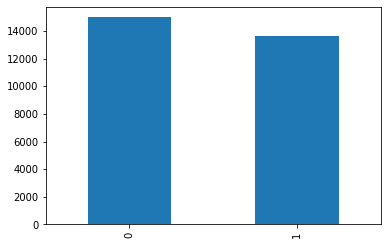

In [9]:
dataset["is_sarcastic"].value_counts().plot(kind = "bar")

### Preparing data for BERT

In [10]:
sequence_length = 512
num_samples = len(dataset)

num_samples, sequence_length

(28619, 512)

### Importing BERT Tokenizer

In [11]:
from transformers import BertTokenizer

### Tokenization

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
tokens = tokenizer(dataset["headline"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

In [14]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokens["input_ids"]

array([[  101,  4228, 14045, ...,     0,     0,     0],
       [  101, 17183, 16360, ...,     0,     0,     0],
       [  101,  4521,  2115, ...,     0,     0,     0],
       ...,
       [  101,  1996,  2087, ...,     0,     0,     0],
       [  101,  7733, 15113, ...,     0,     0,     0],
       [  101,  3611, 18856, ...,     0,     0,     0]])

In [16]:
tokens["attention_mask"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Saving in numpy format

In [17]:
with open("xids.npy", "wb") as f:
  np.save(f, tokens["input_ids"])

In [18]:
with open("xmasks.npy", "wb") as f:
  np.save(f, tokens["attention_mask"])

### Taking target

In [19]:
arr = dataset["is_sarcastic"].values

In [67]:
arr.shape

(28619,)

In [68]:
 arr.max()+1

2

In [69]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(28619, 2)

In [70]:
labels

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [71]:
labels[np.arange(num_samples), arr] = 1

In [74]:
labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

### Saving Labels

In [24]:
with open("labels.npy", "wb") as f:
  np.save(f, labels)

### Creating pipeline

In [25]:
with open("xids.npy", "rb") as f:
  Xids = np.load(f, allow_pickle = True)

with open("xmasks.npy", "rb") as f:
  Xmasks = np.load(f, allow_pickle = True)

with open("labels.npy", "rb") as f:
  labels = np.load(f, allow_pickle = True)


In [26]:
Xids.shape

(28619, 512)

### Creating the tensorflow dataset

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, labels))

In [28]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (2,)), types: (tf.int64, tf.int64, tf.float32)>

In [29]:
def map_fun(input_ids, masks, labels):

  return {"input_ids": input_ids,
          "attention_mask": masks}, labels

In [30]:
dataset = dataset.map(map_fun)

In [31]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (2,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float32)>

### Dataset shuffling

In [32]:
batch_size = 16

In [33]:
dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

<BatchDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 2)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float32)>

In [35]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (2,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float32)>

In [36]:
split = 0.9

In [37]:
Xids.shape

(28619, 512)

In [38]:
int((Xids.shape[0] / batch_size)*split)

1609

In [39]:
size = int((Xids.shape[0] / batch_size)*split)

In [40]:
train_ds = dataset.take(size)

In [41]:
val_ds = dataset.skip(size)

### Saving the data

In [42]:
tf.data.experimental.save(train_ds, "train")
tf.data.experimental.save(val_ds, "val")

In [43]:
train_ds.element_spec == val_ds.element_spec

True

In [44]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None)},
 TensorSpec(shape=(2,), dtype=tf.float32, name=None))

### Loading the dataset

In [45]:
ds = tf.data.experimental.load("train", element_spec = train_ds.element_spec)

In [46]:
ds.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (2,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float32)>

### Building the BERT model

In [47]:
from transformers import TFAutoModel

In [48]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


#### Fine-Tuning the BERT model

In [51]:
input_ids = tf.keras.layers.Input(shape = (512,), name = "input_ids",
                                  dtype = "int32")

mask = tf.keras.layers.Input(shape = (512,), name = "attention_mask",
                                  dtype = "int32")

#### Transformers Embeddings

In [52]:
model.bert(input_ids, attention_mask = mask)[1]

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>

In [53]:
embeddings = model.bert(input_ids, attention_mask = mask)[1]

#### Classifier Head

In [54]:
x = tf.keras.layers.Dense(1024, activation = "relu")(embeddings)
y = tf.keras.layers.Dense(1, activation = "sigmoid", name = "outputs")(x)

#### Creating model

In [55]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[1][1]                   

In [57]:
model.layers[2].trainable = False

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[1][1]                   

### Compiling the model

In [59]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-5, decay = 1e-6)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy("accuracy")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [60]:
model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

In [61]:
ds.element_spec

({'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None)},
 TensorSpec(shape=(2,), dtype=tf.float32, name=None))

In [62]:
element_spec = ds.element_spec

### Loading Train and Val dataset

In [63]:
train_ds = tf.data.experimental.load("train", element_spec = element_spec)
val_ds = tf.data.experimental.load("val", element_spec = element_spec)

In [64]:
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (2,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float32)>

### Callbacks

In [65]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/model", monitor = "val_loss", save_best_only = True, 
                                                verbose = 1)

earlystopping = tf.keras.callbacks.EarlyStopping( monitor = "val_loss", verbose = 1, restore_best_weights = True,
                                                 patience = 2)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                              patience = 1, min_lr = 0.001, verbose = 1)

callbacks = [checkpoint, earlystopping, reduce_lr]

In [66]:
history = model.fit(train_ds, validation_data =  val_ds, epochs = 3, callbacks = callbacks)

Epoch 1/3


ValueError: ignored